In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def L2_loss(u, v):
  return (u-v).pow(2).mean()

class MLP(nn.Module):

    def __init__(self, input_dim, output_dim):

        self.input_dim = input_dim
        self.output_dim = output_dim
        super().__init__()
        N = 64
        self.model = nn.Sequential(
          nn.Linear(self.input_dim, N),
          nn.Sigmoid(),
          nn.Linear(N, N),
          nn.Tanh(),
          nn.Linear(N, N),
          nn.Tanh(),
          nn.Linear(N, self.output_dim)
        )

    def forward(self, x):
        '''Forward pass'''
        output = self.model(x)
        return output


class HNN(nn.Module):

    def __init__(self, input_dim, differentiable_model):
        super(HNN, self).__init__()
        self.input_dim = input_dim
        self.differentiable_model = differentiable_model
        self.M = self.permutation_tensor(input_dim)

    def forward(self, x):
        y = self.differentiable_model(x)
        return y

    def time_derivative(self, x, t=None):
        y = self.forward(x) # traditional forward pass
        J_dy = torch.zeros_like(x) # start out with both components set to 0
        dy = torch.autograd.grad(y.sum(), x, create_graph=True)[0] # gradients for conservative field
        # print(dy)
        M = self.permutation_tensor(self.input_dim)
        # conservative_field = dy @ torch.eye(*self.M.shape)
        J_dy = dy @ M

        return J_dy

    def permutation_tensor(self,n):

        M = torch.eye(n)
        M = torch.cat([M[n//2:], -M[:n//2]])

        return M

In [12]:
import autograd
import autograd.numpy as np

import scipy.integrate
solve_ivp = scipy.integrate.solve_ivp

def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = p**2 + q**2 # spring hamiltonian (linear oscillator)
    return H

def dynamics_fn(t, coords):
    dcoords = autograd.grad(hamiltonian_fn)(coords)
    dqdt, dpdt = np.split(dcoords,2)
    S = np.concatenate([dpdt, -dqdt], axis=-1)
    return S

def get_trajectory(t_span=[0,3], timescale=10, radius=None, y0=None, noise_std=0.1, **kwargs):
    t_eval = np.linspace(t_span[0], t_span[1], int(timescale*(t_span[1]-t_span[0])))
    
    # get initial state
    if y0 is None:
        y0 = np.random.uniform(-10,10,2) # np.random.rand(2)*2-1

    if radius is None:
        radius = np.random.rand()*0.9 + 0.1 # sample a range of radii
    # y0 = y0 / np.sqrt((y0**2).sum()) * radius ## set the appropriate radius

    spring_ivp = solve_ivp(fun=dynamics_fn, t_span=t_span, y0=y0, t_eval=t_eval, rtol=1e-10, **kwargs)
    q, p = spring_ivp['y'][0], spring_ivp['y'][1]
    dydt = [dynamics_fn(None, y) for y in spring_ivp['y'].T]
    dydt = np.stack(dydt).T
    dqdt, dpdt = np.split(dydt,2)
    
    # add noise
    q += 0*np.random.randn(*q.shape)*noise_std
    p += 0*np.random.randn(*p.shape)*noise_std
    return q, p, dqdt, dpdt, t_eval

def get_dataset(seed=0, samples=50, test_split=0.5, **kwargs):
    data = {'meta': locals()}

    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs, ts = [], [], []
    for s in range(samples):
        x, y, dx, dy, t = get_trajectory(**kwargs)
        xs.append( np.stack( [x, y]).T )
        dxs.append( np.stack( [dx, dy]).T )
        ts.append(t)
    data['x'] = np.concatenate(xs)
    data['dx'] = np.concatenate(dxs).squeeze()
    data['t'] = np.concatenate(ts).squeeze()
    # make a train/test split
    split_ix = int(len(data['x']) * test_split)
    split_data = {}
    for k in ['x', 'dx','t']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

def get_field(xmin=-1.2, xmax=1.2, ymin=-1.2, ymax=1.2, gridsize=20):
    field = {'meta': locals()}

    # meshgrid to get vector field
    b, a = np.meshgrid(np.linspace(xmin, xmax, gridsize), np.linspace(ymin, ymax, gridsize))
    ys = np.stack([b.flatten(), a.flatten()])
    
    # get vector directions
    dydt = [dynamics_fn(None, y) for y in ys.T]
    dydt = np.stack(dydt).T

    field['x'] = ys.T
    field['dx'] = dydt.T
    return field

In [3]:
data = get_dataset(seed=0,samples=2)
print(data['dx'])
# M = torch.eye(2)
# print(torch.eye(*M.shape))

[[ 4.30378733 -0.97627008]
 [ 4.17996585 -1.41547697]
 [ 4.01145209 -1.83954893]
 [ 3.80004788 -2.24395302]
 [ 3.54801355 -2.62436424]
 [ 3.25804383 -2.9767161 ]
 [ 2.93323903 -3.29724072]
 [ 2.57707218 -3.58251121]
 [ 2.19335101 -3.82947761]
 [ 1.78617887 -4.03549894]
 [ 1.35990848 -4.19837303]
 [ 0.91909843 -4.31635772]
 [ 0.46846088 -4.38819225]
 [ 0.01281503 -4.41310789]
 [-0.44296825 -4.3908388 ]
 [-0.89401504 -4.32162265]
 [-1.33550309 -4.20619982]
 [-1.76271205 -4.04580415]
 [-2.17107377 -3.84215086]
 [-2.55622279 -3.59741711]
 [-2.91404012 -3.31421996]
 [-3.24070108 -2.99558693]
 [-3.53271187 -2.64492533]
 [-3.7869514  -2.26598391]
 [-4.00070042 -1.86281479]
 [-4.1716742  -1.43972833]
 [-4.29804427 -1.00124827]
 [-4.37845965 -0.55206304]
 [-4.41206051 -0.09697496]
 [-4.39848759  0.35914975]]


In [13]:

# set random seed
# torch.manual_seed(1)
# np.random.seed(1)
numSamples = 50
total_steps = 1000

nn_model = MLP(2, 1)
model = HNN(2, differentiable_model=nn_model)
optim = torch.optim.Adam(model.parameters(), lr = 1e-2, weight_decay=1e-4)

# arrange data
data = get_dataset(seed = 5, samples = numSamples, test_split= 0.8)
x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32)
test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32)
dxdt = torch.Tensor(data['dx'])
test_dxdt = torch.Tensor(data['test_dx'])

# vanilla train loop
stats = {'train_loss': [], 'test_loss': []}
for step in range(total_steps+1):
  
    # train step
    dxdt_hat = model.time_derivative(x)
    loss = L2_loss(dxdt, dxdt_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()
  
    # run test data
    test_dxdt_hat = model.time_derivative(test_x)
    test_loss = L2_loss(test_dxdt, test_dxdt_hat)

    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
  
train_dxdt_hat = model.time_derivative(x)
train_dist = (dxdt - train_dxdt_hat)**2
test_dxdt_hat = model.time_derivative(test_x)
test_dist = (test_dxdt - test_dxdt_hat)**2
print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
  .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
          test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))


Final train loss 7.5535e-04 +/- 7.7324e-05
Final test loss 1.6087e-01 +/- 3.5496e-02


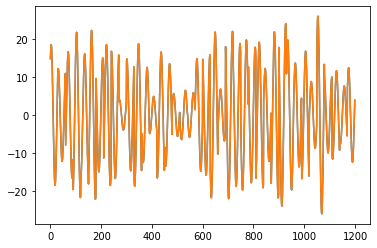

In [14]:
plt.plot(dxdt[:,0])
plt.plot(train_dxdt_hat.detach().numpy()[:,0])

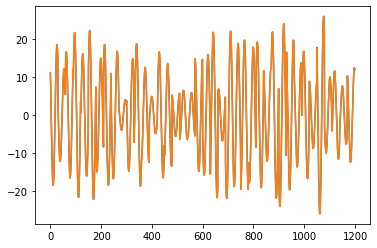

In [15]:
plt.plot(dxdt[:,1])
plt.plot(train_dxdt_hat.detach().numpy()[:,1])

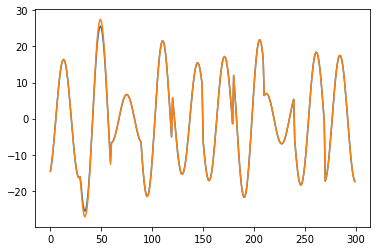

In [16]:
plt.plot(test_dxdt[:,0])
plt.plot(test_dxdt_hat.detach().numpy()[:,0])

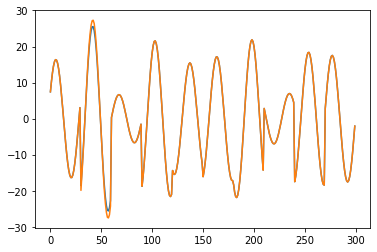

In [17]:
plt.plot(test_dxdt[:,1])
plt.plot(test_dxdt_hat.detach().numpy()[:,1])

In [18]:
model.forward(x)[31]

tensor([56.6626], grad_fn=<SelectBackward0>)

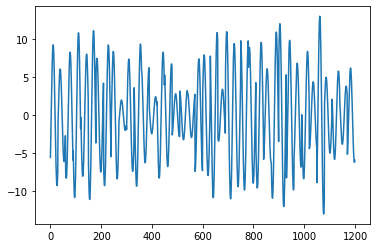

In [19]:
plt.plot(data['x'][:,0])

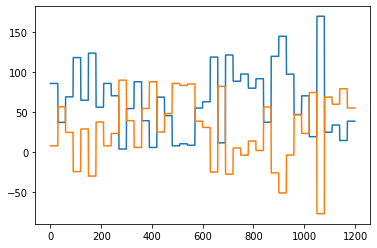

In [20]:
plt.plot(data['x'][:,1]**2+data['x'][:,0]**2)
plt.plot(model.forward(x).detach().numpy())

In [ ]:
plt.plot(x.detach().numpy()[:,0],x.detach().numpy()[:,1])

In [ ]:
x.detach().numpy()[:,1]**2+x.detach().numpy()[:,0]**2